In [13]:
from PIL import Image
import numpy
import os
import re
from resizeimage import resizeimage
import matplotlib.pyplot as plt

In [2]:
# resize images
# resizeImages('../data/yalefaces/', 'subject01')
def resizeImages(path, prefix):    
    for root, dirs, files in os.walk(path):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(path + name)
                resizedImg = resizeimage.resize_height(img, 50)
                resizedImg.save('yalefaces_resized/'+name)

# images into array: http://stackoverflow.com/questions/13550376/pil-image-to-array-numpy-array-to-array-python
def readImagesIntoMatrix(path, prefix):
    images = None
    for root, dirs, files in os.walk(path):
        for name in files:
            if re.match(r'^'+prefix+'.*gif$', name, re.I):
                img = Image.open(path + name)
                (width, height) = img.size
                imgArr = numpy.asarray(img).reshape(height * width)
                if images is not None:
                    images = numpy.vstack([images, imgArr])
                else:
                    images = imgArr
    return images

In [3]:
#resizeImages('yalefaces/', 'subject.*')
imageList = readImagesIntoMatrix('yalefaces_resized/', 'subject.*happy').T

#Image.fromarray(numpy.uint8(imageList.T[0].reshape(50,66))).save("test/testsaveimage1.gif")

In [4]:
(width, height) = 66, 50
# average Image
avgImg =  numpy.mean(imageList, axis=1)
#Image.fromarray(numpy.uint8(avgImg.reshape(50,66))).save('test/avgImg.gif')

In [7]:
# Subtract mean from each column (which are rows of transpose, how numpy does it)
imagesDiff = (imageList.T - avgImg).T

# Get EigenVectors
covMatrix = numpy.cov(imagesDiff, rowvar=True)
eigenVal, eigenVec = numpy.linalg.eigh(covMatrix)

# Sort eigenvectors
# http://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
idx = eigenVal.argsort()[::-1]
eigenVal = eigenVal[idx]
eigenVec = eigenVec[:,idx]

3820481.71759


In [ ]:
# Testing the eigenvectors
# Taken from http://sebastianraschka.com/Articles/2014_pca_step_by_step.html
for i in range(len(eigenVal)):
    eigv = eigenVec[:,i].reshape(1,3300).T
    numpy.testing.assert_array_almost_equal(covMatrix.dot(eigv), eigenVal[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

# Also lets assert the eigenvectors are orthogonal
for i in range(len(eigenVal)):
    for j in range(len(eigenVal)):
        if i < j:
            break # Comment this out if you want to run this silly test
            # Commented out because if you run this it takes FOREVER.
            # numpy.testing.assert_almost_equal(0, eigenVec[i].T.dot(eigenVec[j]))

In [67]:
def normalize_face(vector):
    minValue = numpy.amin(vector)
    maxValue = numpy.amax(vector)
    scale = (255./(maxValue-minValue))
    return (vector - minValue)*scale

for i in range (1, 100):
    eigv = eigenVec[:,i].reshape(1,3300).T
    eigenface = normalize_face(eigv)
    #Image.fromarray(numpy.uint8(eigenface.reshape(50,66))).save('test/happy_eigenface%s.gif' % i)

In [68]:
def top_k_eigenface(image, eigenVectors, k):
    start_vector = numpy.zeros((50*66))
    for i in range(0, k-1):
        eigv = eigenVec[:,i].reshape(3300)
        weight = numpy.inner(image, eigv)
        start_vector = start_vector + weight * eigv
    return start_vector

numComponents = 13
projections = []
for i in range(0, len(imagesDiff.T)):
    projection = top_k_eigenface(imagesDiff.T[i].reshape(3300), eigv, numComponents)+avgImg
    projections.append(projection)
    #print ('Projection dimensions %s' % (projection.shape,))
    #Image.fromarray(numpy.uint8(projection.reshape(50,66))).save('test/happy_13_projection_of_subject%s.gif' % i)
    projection = top_k_eigenface(imagesDiff.T[i].reshape(3300), eigv, 3300)+avgImg
    #Image.fromarray(numpy.uint8(projection.reshape(50,66))).save('test/happy_3300_projection_of_subject%s.gif' % i)

# Analysis

### Variance Explained thru Eigenvalues
- About 90% of variance can be explained by 9 principal components
- Almost all the variance can be explained by the first 15 components. This is because we are taking 1 image from of the the 15 subjects as our image data set, with a total of 15 images.

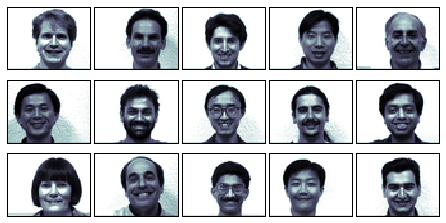

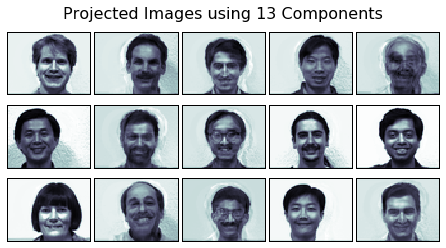

In [100]:
# Plot the images we are using
fig = plt.figure(figsize=(6,3)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
fig2.suptitle('Original Images', y=1.1, fontsize=16)

for i in range(15):
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks=[])
    ax.imshow(imageList.T[i].reshape(50, 66), cmap=plt.cm.bone, interpolation='nearest')

# Plot the projected Images
numComponents = 13

fig2 = plt.figure(figsize=(6,3)) 
fig2.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(15):
    ax = fig2.add_subplot(3, 5, i+1, xticks=[], yticks=[])
    ax.imshow(projections[i].reshape(50, 66), cmap=plt.cm.bone, interpolation='nearest')

fig2.suptitle('Projected Images using ' + str(numComponents) + ' Components', y=1.1, fontsize=16)

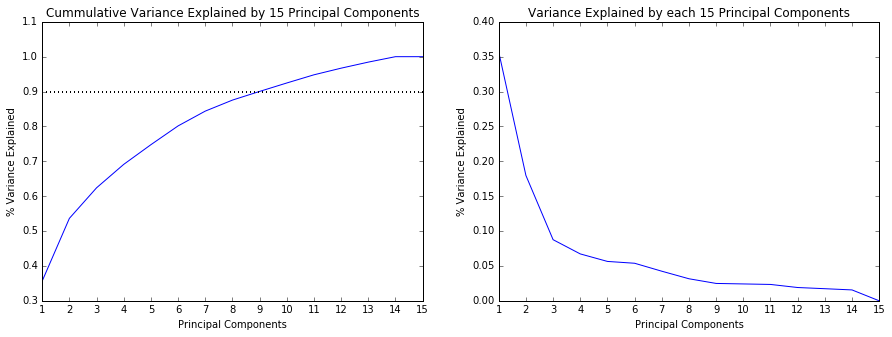

In [65]:
%matplotlib inline
totalEigenVal =  numpy.sum(eigenVal)
relativeEigenVal = eigenVal/totalEigenVal
# plot cumulative histogram for how much variance is accounted for with each principal component
numComponents = 15 # look at the first 20 components
curSum = 0
cumData = []
for idx, val in enumerate(relativeEigenVal[:numComponents]):
    curSum = curSum + val
    cumData.append(curSum)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(range(1, numComponents+1), cumData);
ax.set_title('Cummulative Variance Explained by ' + str(numComponents) + ' Principal Components')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')
plt.xticks(range(1, numComponents+1))

# add line to indicate 90% variance line
plt.plot([1, 15], [0.9, 0.9], 'k:', lw=2)

plt.margins(x=0)

ax = fig.add_subplot(122)
ax.plot(range(1, numComponents+1), relativeEigenVal[:numComponents]);
ax.set_title('Variance Explained by each ' + str(numComponents) + ' Principal Components')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')
plt.xticks(range(1, numComponents+1))
plt.margins(x=0)

plt.show()

### Adding Noise

#### Gaussian noise

In [150]:
import copy

def addGaussianNoise(image):
    noisyImage = copy.deepcopy(image)
    mu = noisyImage.mean()
    std = noisyImage.std()
    noise = 0.2 * numpy.random.normal(mu, std, noisyImage.shape)
    print noise
    for idx, val in enumerate(noisyImage):
        noisyImage[idx] = 255 if val + noise[idx] >= 255 else val + noise[idx] 

    return noisyImage

def addMixtureNoise(image):
    noisyImage = copy.deepcopy(image)
    
    mu1 = noisyImage.mean()
    std1 = 20
    noise1 = numpy.random.normal(mu1, std1, noisyImage.shape) - mu1
    mu2 = noisyImage.mean()
    std2 = 5
    noise2 = numpy.random.normal(mu2, std2, noisyImage.shape) - mu2 + 10
    for idx, val in enumerate(noisyImage):
        noise = noise1[idx] + noise2[idx] + noisyImage[idx];
        val = 0
        if noise >= 255:
            val = 255
        elif noise <= 0:
            val = 0
        else:
            val = noise
        
        noisyImage[idx] = val

    return noisyImage    
    
img = Image.open('yalefaces/subject01.gif')
print img.size
(width, height) = img.size
imgArr = numpy.asarray(img).reshape(height * width)
print Image.fromarray(numpy.uint8(addMixtureNoise(imgArr).reshape(height,width))).save("test/noisy2.gif")

(320, 243)
None
